In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [3]:
pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import os
import csv

dataset_dir = "C:\\Users\\USER\\OneDrive\\Desktop\\Mango"  # Replace with your actual dataset directory
csv_file = "metadata_mango.csv"

with open(csv_file, 'w', newline='') as csvfile:
    fieldnames = ['Filename', 'Disease']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for disease_folder in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, disease_folder)):
            disease_name = disease_folder
            image_files = os.listdir(os.path.join(dataset_dir, disease_folder))
            for image_file in image_files:
                # Convert the relative path to an absolute path
                image_path = os.path.abspath(os.path.join(dataset_dir, disease_folder, image_file))
                writer.writerow({'Filename': image_path, 'Disease': disease_name})



In [2]:
import csv

csv_file = "metadata_mango.csv"

with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)


['Filename', 'Disease']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124249 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124250 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124252 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124253 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124256 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124301 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124302 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124305 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Mango\\Anthracnose\\20211008_124306 (Custom).jpg', 'Anthracnose']
['C:\\Users\\USER\\OneDrive\\Desktop\\Ma

In [46]:
import pandas as pd

# Load your dataset
data = pd.read_csv("metadata_mango.csv")  # Replace with your dataset file

# Assuming you have a 'Disease' column for labels
class_counts = data['Disease'].value_counts()

# Calculate the support proportion for each class
total_samples = len(data)
support_proportions = class_counts / total_samples

# Print or use the support proportions as needed
print("Support Proportions:")
print(support_proportions)


Support Proportions:
Disease
Anthracnose         0.125
Bacterial Canker    0.125
Cutting Weevil      0.125
Die Back            0.125
Gall Midge          0.125
Healthy             0.125
Powdery Mildew      0.125
Sooty Mould         0.125
Name: count, dtype: float64


In [5]:
# 2nd model training code that stores the history during training

import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("metadata_mango.csv")

file_paths = data['Filename'].tolist()
labels = data['Disease'].tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

images = []
for file_path in file_paths:
    img = load_img(file_path, target_size=(224, 224))
    img = img_to_array(img) / 255.0
    images.append(img)

images = np.array(images)
labels = to_categorical(labels, num_classes=np.max(labels) + 1)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

batch_size = 32
num_classes = labels.shape[1]
num_epochs = 20

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator()

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_generator,
    validation_steps=len(val_images) // batch_size,
    epochs=num_epochs,
)
  
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=batch_size)

model.save("disease_detector.h5")

print(f"Test accuracy: {test_accuracy}")


Epoch 1/20
100/100 [==============================] - 635s 6s/step - loss: 0.1895 - accuracy: 0.9456 - val_loss: 2.5406 - val_accuracy: 0.0990
Epoch 2/20
100/100 [==============================] - 603s 6s/step - loss: 0.0293 - accuracy: 0.9928 - val_loss: 2.1799 - val_accuracy: 0.1276
Epoch 3/20
100/100 [==============================] - 580s 6s/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 2.8532 - val_accuracy: 0.1328
Epoch 4/20
100/100 [==============================] - 610s 6s/step - loss: 0.0223 - accuracy: 0.9941 - val_loss: 5.2172 - val_accuracy: 0.1276
Epoch 5/20
100/100 [==============================] - 597s 6s/step - loss: 0.0356 - accuracy: 0.9937 - val_loss: 2.1691 - val_accuracy: 0.2682
Epoch 6/20
100/100 [==============================] - 612s 6s/step - loss: 0.0217 - accuracy: 0.9962 - val_loss: 2.4541 - val_accuracy: 0.1458
Epoch 7/20
100/100 [==============================] - 594s 6s/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 2.3567 - val_accuracy: 0.2318

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy: 0.987500011920929


In [1]:
pip install scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.4 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.4/60.4 kB 1.6 MB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/156.8 kB ? eta -:--:--
     --------------- ----------------------- 61.4/156.8 kB 3.2 MB/s eta 0:00:01
     -------------------------------------  153.6/156.8 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 156.8/156.8 kB 1.9 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached pytz-2023.3.post1-py2.py3-none-an

13/13 [==============================] - 17s 1s/step
Accuracy: 0.9475
Precision: 0.9603
F1 Score: 0.9463
Confusion Matrix:
[[55  0  0  0  1  0  0  0]
 [ 1 37  0  0 18  0  0  0]
 [ 0  0 55  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0]
 [ 0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0 51  0]
 [ 0  0  0  0  0  0  1 45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        56
           1       1.00      0.66      0.80        56
           2       1.00      1.00      1.00        55
           3       1.00      1.00      1.00        46
           4       0.73      1.00      0.85        52
           5       1.00      1.00      1.00        38
           6       0.98      1.00      0.99        51
           7       1.00      0.98      0.99        46

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.

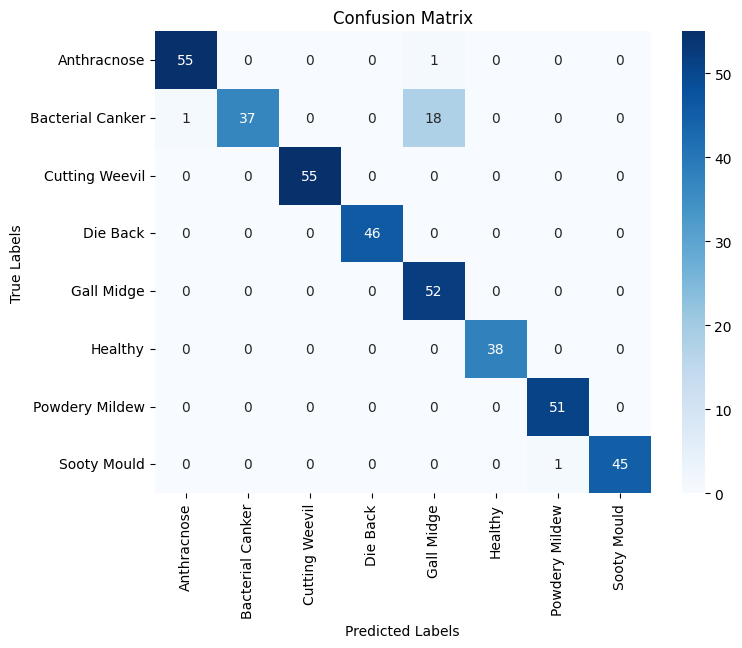

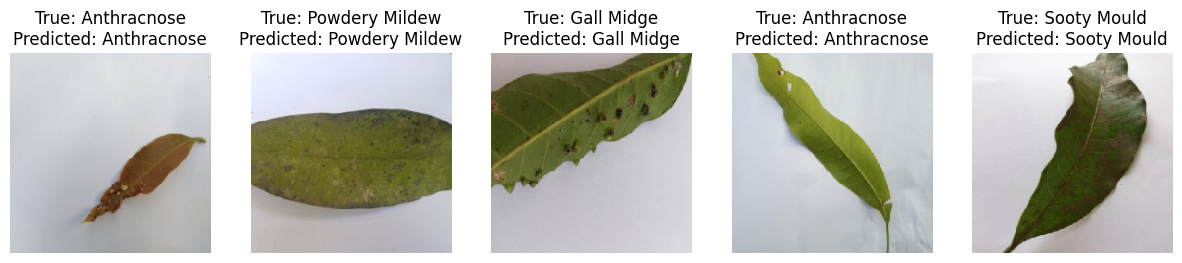

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the model
model = load_model("mango_disease_model.h5")

# Load the data
data = pd.read_csv("metadata_mango.csv")

file_paths = data['Filename'].tolist()
labels = data['Disease'].tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

images = []
for file_path in file_paths:
    img = load_img(file_path, target_size=(224, 224))
    img = img_to_array(img) / 255.0
    images.append(img)

images = np.array(images)
labels = to_categorical(labels, num_classes=np.max(labels) + 1)

# Split the data
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Predictions on the test set
test_predictions = model.predict(test_images)
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.4f}")

# F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plotting a few sample images with predictions
num_samples = 5
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices, 1):
    plt.subplot(1, num_samples, i)
    plt.imshow(test_images[idx])
    plt.title(f"True: {label_encoder.classes_[true_labels[idx]]}\nPredicted: {label_encoder.classes_[predicted_labels[idx]]}")
    plt.axis('off')
plt.show()


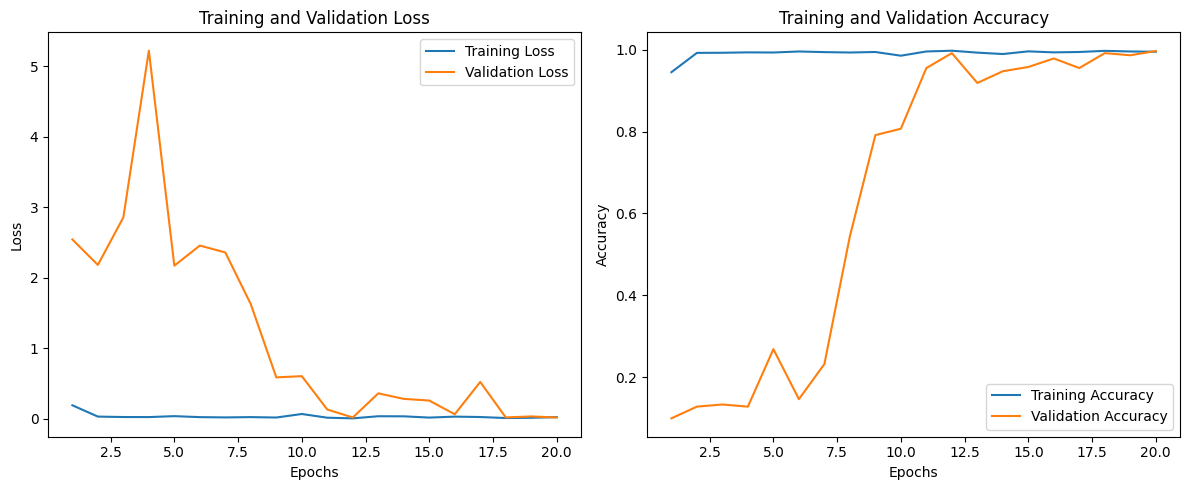

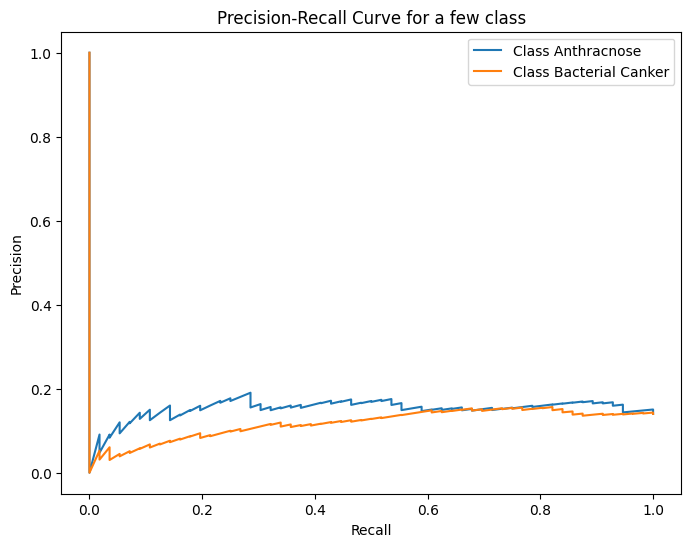

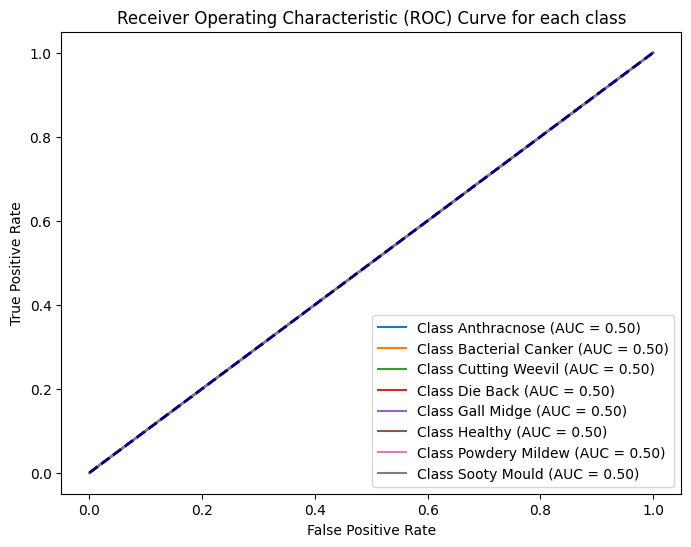

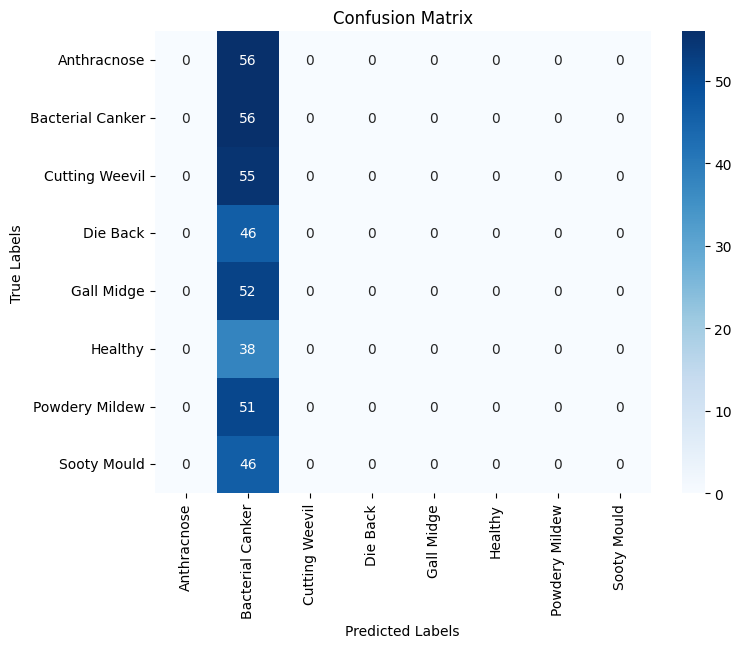

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
import seaborn as sns

# Extract information from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, num_epochs + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Binarize the true labels for precision-recall curve
binarized_labels = label_binarize(true_labels, classes=range(num_classes))

# Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    try:
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], test_predictions[:, i])
        plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]}')
    except IndexError:
        pass  # Ignore classes with no samples in the test set

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for a few class')
plt.legend()
plt.show()

# Convert true labels and predictions to one-hot encoded format
true_labels_one_hot = to_categorical(true_labels, num_classes=num_classes)
test_predictions_one_hot = to_categorical(np.argmax(test_predictions, axis=1), num_classes=num_classes)

# ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], test_predictions_one_hot[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, (test_predictions[:, 1] > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
